# Classification, part 2

This notebook will provide exercises for the second learning unit on classification (learning unit 2). It will address the following topics:

- Brief return to logistic regression to refresh your memory
- Nonparametric density estimation (we already saw the histogram, but will also look at kernel estimators)
- Curse of dimensionality
- k-nearest neighbor algorithm
- Condensed nearest neighbor algorithm
- Decision trees
- Pruning decision trees (pre- and post-pruning)
- Impurity in decision trees
- Regression trees
- Rule extraction from trees
- Ripper algorithm

The aim of the notebook is to help with the understanding of these topics. This is the first version of the notebook, so you are likely to find some inconsistencies or errors. Please let the teaching team know so that we can update the notebook.

## Exercise 1

In the first notebook on classification we showed the rationale behind the logistic regression. Instead of fitting a straight line, a sigmoid function is fitted through the data points.

We did not actually fit the model to the data and examine how well the fit is.

- Look up the plot from the end of the previous notebook and try to predict whether you expect a good fit on the basis of this plot
- Load the data from the Chicago face database
- Split the data between 80% training and 20%
- Fit the logistic regression model on the training data
- Compute the accuracy for the training data and the test data
- Do the scores suggest overfitting?

In [2]:
# Answer exercise 1
#Based on the plot and what the data entail (femininity ratings and female gender), we predict a good fit. A guestimate would be around 85% or higher.

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
path = "/home/frouke/Documents/OU/MachineLearning/Classification/" #replace with your own path

faces = pd.read_csv(path + "chicagoRatings.csv")

X = faces[["Feminine"]]
y = faces["Gender"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
train_acc_lr = lr_model.score(X_train, y_train)
test_acc_lr = lr_model.score(X_test, y_test)
print("Accuracy train/test LR:", train_acc_lr, test_acc_lr) #Performance is even better than expected
# The accuracy is higher on the training set, but still very good on the test set. There might be a little bit of overfitting (but check other values of the random state).


Accuracy train/test LR: 0.9916142557651991 0.975


# Nonparametric density estimation

There are various methods to get a sense of the distribution of continuous data in your dataset. In the first notebook on classification we already saw the histogram. In the answers we used subplots to compare the histogram of age across races. This comparison can also be done by first estimating the density and then plot these densities together. Let's first repeat the code for the histogram.

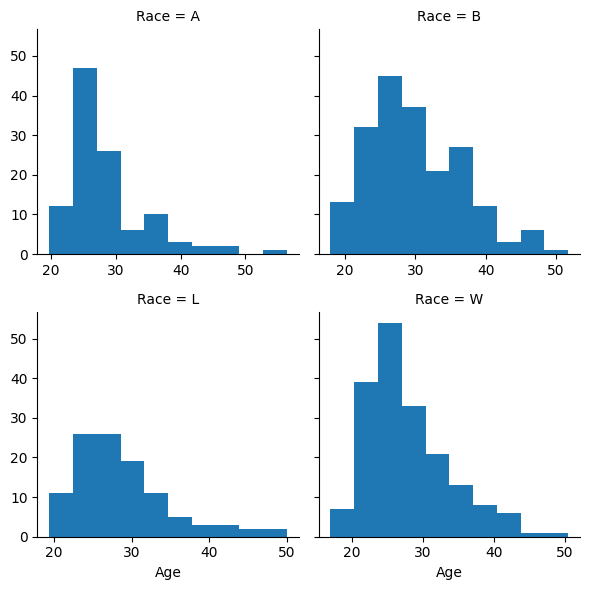

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(faces, col="Race", col_wrap=2, sharex=False)
g.map(plt.hist, "Age")

Seaborn has an option to directly plot the density, but let's instead compute it first and then plot it. The following code does this across races in the dataset.

<Axes: xlabel='age', ylabel='density'>

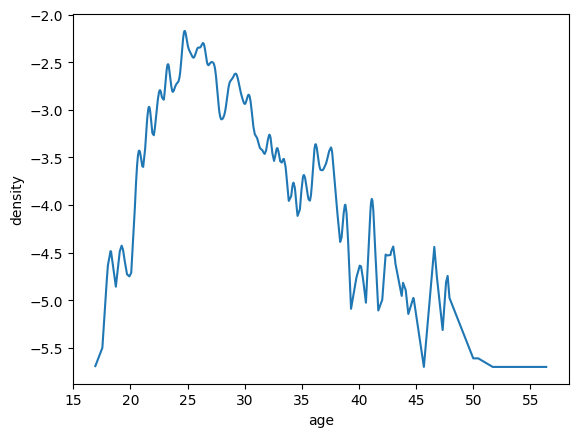

In [4]:
#Code from: https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

from sklearn.neighbors import KernelDensity
import numpy as np

#Create a numpy array with age
X = faces["Age"].to_numpy()

#Create the estimator
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X[:, None])

#Compute the density
density = kde.score_samples(X[:, None]) #compute the density

# Create a data-frame and sort it by age
density = pd.DataFrame({"age": X, "density": density}).sort_values(by=['age'])

#Create the lineplot
sns.lineplot(density, x = "age", y = "density")


## Exercise 2

The density plot looks a bit noisy. Examine what happens if you change the bandwidth to a higher or a lower value.

<Axes: xlabel='age', ylabel='density'>

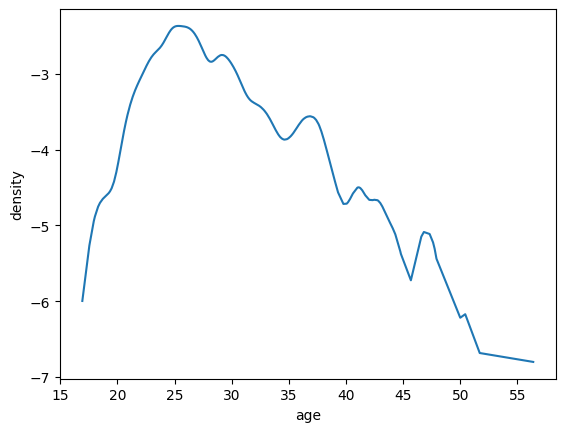

In [5]:
#Exercise 2 answer

#Higher bandwidth
kde = KernelDensity(kernel='gaussian', bandwidth=0.6).fit(X[:, None])
density = kde.score_samples(X[:, None]) #compute the density
density = pd.DataFrame({"age": X, "density": density}).sort_values(by=['age'])
sns.lineplot(density, x = "age", y = "density")
#Produces more smoothing

<Axes: xlabel='age', ylabel='density'>

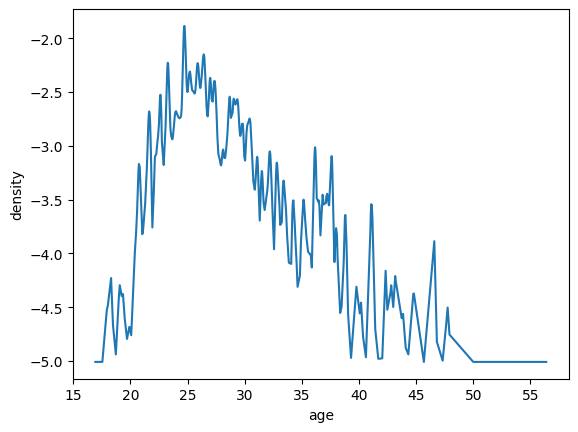

In [6]:
#Exercise 2 answer

#Lower bandwidth
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(X[:, None])
density = kde.score_samples(X[:, None]) #compute the density
density = pd.DataFrame({"age": X, "density": density}).sort_values(by=['age'])
sns.lineplot(density, x = "age", y = "density")
#Produces less smoothing

## Exercise 3

Now create the density per race and plot these in the same graph with different colours. Use the 0.6 bandwidth.

<Axes: xlabel='age', ylabel='density'>

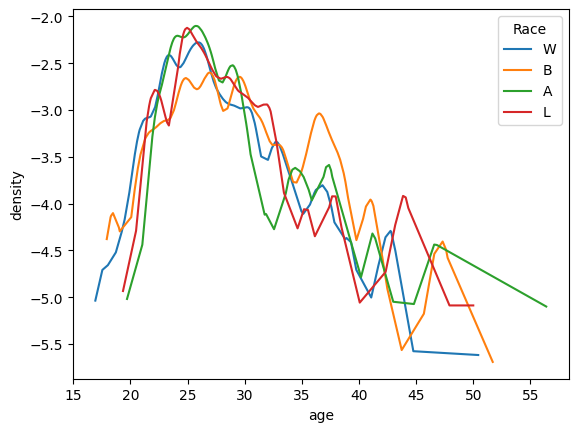

In [7]:
#Answer exercise 3
# There are probably other and more efficient ways to do this

#List the races. Can also be done with a "unique" on this column
races = ["W", "B", "A", "L"]

#Loop through the races
for idx, race in enumerate(races):
    x = faces[faces["Race"] == race] #select rows for that race
    x = x["Age"].to_numpy() #then compute the density
    kde = KernelDensity(kernel='gaussian', bandwidth=0.6).fit(x[:, None])
    density = kde.score_samples(x[:, None]) #compute the density
    if idx == 0: #create a new dataframe for the first race in the list
        df = pd.DataFrame({"age": x, "density": density}).sort_values(by=['age'])
        df["Race"] = race #Add a column for race
    else: #Append to the dataframe for the next races in the list
        temp = pd.DataFrame({"age": x, "density": density}).sort_values(by=['age'])
        temp["Race"] = race
        df = pd.concat([df, temp])

#Plot the data with Seaborn
sns.lineplot(df, x = "age", y = "density", hue = "Race")

# Curse of dimensionality

Machine learning algorithms can start to struggle when you have a lot of features. With many features, there is an increased risk of overfitting (the algorithm generalising poorly). One method to deal with this curse of dimensionality is to perform feature reduction before fitting the model. Let's try this with the k-nearest-neighbor algorithm, which is known to be prone to this curse. We use k = 3, because this yields a large difference between the training accuracy and test accuracy.

In [8]:
X = faces[['Luminance_median', 'Nose_Width', 'Nose_Length',
       'Lip_Thickness', 'Face_Length', 'R_Eye_H', 'L_Eye_H', 'Avg_Eye_Height',
       'R_Eye_W', 'L_Eye_W', 'Avg_Eye_Width', 'Face_Width_Cheeks',
       'Face_Width_Mouth', 'Forehead', 'Pupil_Top_R', 'Pupil_Top_L',
       'Asymmetry_pupil_top', 'Pupil_Lip_R', 'Pupil_Lip_L',
       'Asymmetry_pupil_lip', 'BottomLip_Chin', 'Midcheek_Chin_R',
       'Midcheek_Chin_L', 'Cheeks_avg', 'Midbrow_Hairline_R',
       'Midbrow_Hairline_L', 'Faceshape', 'Heartshapeness', 'Noseshape',
       'LipFullness', 'EyeShape', 'EyeSize', 'UpperHeadLength',
       'MidfaceLength', 'ChinLength', 'ForeheadHeight', 'CheekboneHeight',
       'CheekboneProminence', 'FaceRoundness', 'fWHR']] #all the facial features

y = faces['Race'] #race to be predicted

from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42) #split data
model = KNeighborsClassifier(n_neighbors=3) 
model.fit(X_train, y_train)#fit model
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)

print("Train/test acc:", train_acc, test_acc)



Train/test acc: 0.8574423480083857 0.6583333333333333


Now we use feature selection and dimensionality reduction and compare the effects on the difference between training and test accuracy.

From: https://www.geeksforgeeks.org/curse-of-dimensionality-in-machine-learning/



In [9]:
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.decomposition import PCA

# Perform feature selection
selector_kbest = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector_kbest.fit_transform(X_train, y_train)
X_test_selected = selector_kbest.transform(X_test)

# Perform dimensionality reduction
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

## Exercise 4

Fit the k-NN model with k = 3 on the selected and pca featuers and then apply these models to the test set. What happens to the difference between training and test accuracy?

In [10]:
# Answer exercise 4a

model.fit(X_train_selected, y_train)#fit model
train_acc = model.score(X_train_selected, y_train)
test_acc = model.score(X_test_selected, y_test)

print("Train/test acc:", train_acc, test_acc)

Train/test acc: 0.8553459119496856 0.775


In [11]:
#Answer exercise 4b
model.fit(X_train_pca, y_train)#fit model
train_acc = model.score(X_train_pca, y_train)
test_acc = model.score(X_test_pca, y_test)

print("Train/test acc:", train_acc, test_acc)

Train/test acc: 0.8113207547169812 0.575


## Exercise 5

The results are mixed. Maybe the outcomes depend on the values for the number of selected features or components. Vary the number of features between 5 and 15 and plot the training and test accuracy as a function of this number of features. Do the same for the PCA components, but vary these between 3 and 10.

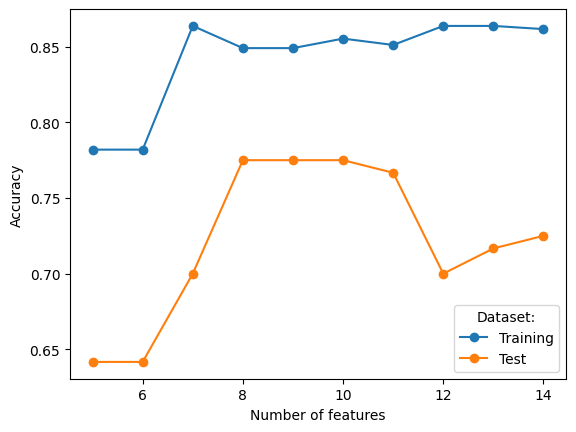

In [12]:
# Answer exercise 5a
nr_features = list(range(5, 15))

train_acc = []
test_acc = []
for nr_feat in nr_features:
    selector_kbest = SelectKBest(score_func=f_classif, k=nr_feat)
    X_train_selected = selector_kbest.fit_transform(X_train, y_train)
    X_test_selected = selector_kbest.transform(X_test)
    model.fit(X_train_selected, y_train)#fit model
    train_acc.append(model.score(X_train_selected, y_train))
    test_acc.append(model.score(X_test_selected, y_test))


plt.plot(nr_features, train_acc, 'o-', label = "Training")
plt.plot(nr_features, test_acc, 'o-', label = "Test")
plt.legend(title='Dataset:')
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.show()

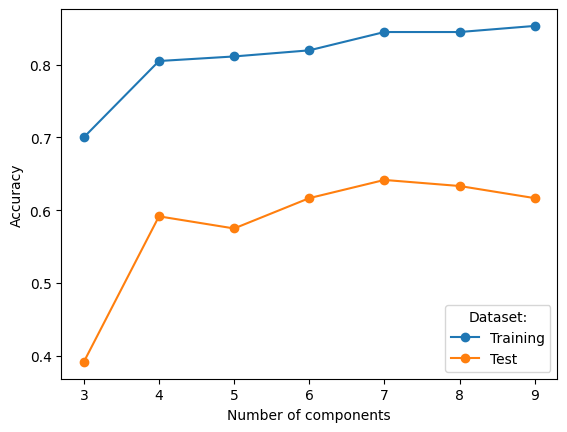

In [13]:
# Answer exercise 5b
nr_components = list(range(3, 10))

train_acc = []
test_acc = []
for nr_comp in nr_components:
    pca = PCA(n_components=nr_comp)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    model.fit(X_train_pca, y_train)#fit model
    train_acc.append(model.score(X_train_pca, y_train))
    test_acc.append(model.score(X_test_pca, y_test))


plt.plot(nr_components, train_acc, 'o-', label = "Training")
plt.plot(nr_components, test_acc, 'o-', label = "Test")
plt.legend(title='Dataset:')
plt.xlabel("Number of components")
plt.ylabel("Accuracy")
plt.show()

## Exercise 6

The blog suggests that a better generalisation can be obtained by first selecting features and then performing a PCA.

Examine the effect of first selecting the best 8 features and then reducing this further to 4 components.

                                                                                                       
                                                                                                    
                                                                                                       

In [14]:
#Answer exercise 6

# Perform feature selection
selector_kbest = SelectKBest(score_func=f_classif, k=8)
X_train_selected = selector_kbest.fit_transform(X_train, y_train)
X_test_selected = selector_kbest.transform(X_test)

# Perform dimensionality reduction
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train_selected)
X_test_pca = pca.transform(X_test_selected)

model.fit(X_train_pca, y_train)#fit model
train_acc = model.score(X_train_pca, y_train)
test_acc = model.score(X_test_pca, y_test)

print("Train-test accuracy:", train_acc, test_acc)

Train-test accuracy: 0.8364779874213837 0.7583333333333333


# K nearest neighbor algorithm

Online you can find several implementations of the k-NN algorithm, built from scratch. We here use the code from:
https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/

In [15]:
from math import sqrt
# Calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
 distance = 0.0
 for i in range(len(row1)-1):
     distance += (row1[i] - row2[i])**2
 return sqrt(distance)
 
# Locate the most similar neighbors
def get_neighbors(train, test_row, num_neighbors):
 distances = list()
 for train_row in train:
     dist = euclidean_distance(test_row, train_row)
     distances.append((train_row, dist))
     distances.sort(key=lambda tup: tup[1])
     neighbors = list()
 for i in range(num_neighbors):
    neighbors.append(distances[i][0])
 return neighbors

## Exercise 7

Take the first and second row from faces and compute the distance between the two observations on the basis of the facial features using the function above. Start with the following line of code for the facial features. Then do the same for the first and last row in the dataframe (which are from different races).

features = faces[['Luminance_median', 'Nose_Width', 'Nose_Length',
       'Lip_Thickness', 'Face_Length', 'R_Eye_H', 'L_Eye_H', 'Avg_Eye_Height',
       'R_Eye_W', 'L_Eye_W', 'Avg_Eye_Width', 'Face_Width_Cheeks',
       'Face_Width_Mouth', 'Forehead', 'Pupil_Top_R', 'Pupil_Top_L',
       'Asymmetry_pupil_top', 'Pupil_Lip_R', 'Pupil_Lip_L',
       'Asymmetry_pupil_lip', 'BottomLip_Chin', 'Midcheek_Chin_R',
       'Midcheek_Chin_L', 'Cheeks_avg', 'Midbrow_Hairline_R',
       'Midbrow_Hairline_L', 'Faceshape', 'Heartshapeness', 'Noseshape',
       'LipFullness', 'EyeShape', 'EyeSize', 'UpperHeadLength',
       'MidfaceLength', 'ChinLength', 'ForeheadHeight', 'CheekboneHeight',
       'CheekboneProminence', 'FaceRoundness', 'fWHR']] 

In [16]:
# Answer exercise 7

features = faces[['Luminance_median', 'Nose_Width', 'Nose_Length',
       'Lip_Thickness', 'Face_Length', 'R_Eye_H', 'L_Eye_H', 'Avg_Eye_Height',
       'R_Eye_W', 'L_Eye_W', 'Avg_Eye_Width', 'Face_Width_Cheeks',
       'Face_Width_Mouth', 'Forehead', 'Pupil_Top_R', 'Pupil_Top_L',
       'Asymmetry_pupil_top', 'Pupil_Lip_R', 'Pupil_Lip_L',
       'Asymmetry_pupil_lip', 'BottomLip_Chin', 'Midcheek_Chin_R',
       'Midcheek_Chin_L', 'Cheeks_avg', 'Midbrow_Hairline_R',
       'Midbrow_Hairline_L', 'Faceshape', 'Heartshapeness', 'Noseshape',
       'LipFullness', 'EyeShape', 'EyeSize', 'UpperHeadLength',
       'MidfaceLength', 'ChinLength', 'ForeheadHeight', 'CheekboneHeight',
       'CheekboneProminence', 'FaceRoundness', 'fWHR']] 

row1 = features.iloc[0].to_numpy()
row2 = features.iloc[1].to_numpy()

distance  = euclidean_distance(row1, row2)
print(distance)

row1 = features.iloc[0].to_numpy()
row2 = features.iloc[-1].to_numpy()

distance  = euclidean_distance(row1, row2)
print(distance)

129.7831046264105
417.86925470402116


## Exercise 8

With the above function, find the three nearest neighbours for row 1 of the dataframe. Modify the code so that you also get the indices of the nearest neighbours and the distance to the first row. Print the indices and the distances.

In [17]:
# Answer exercise 8

def get_neighbors(train, test_row, num_neighbors):
 distances = list()
 n_distance = list()
 indices = list()
 for idx, train_row in enumerate(train):
     dist = euclidean_distance(test_row, train_row)
     distances.append((train_row, dist, idx))
     distances.sort(key=lambda tup: tup[1])
     neighbors = list()
 for i in range(num_neighbors):
    neighbors.append(distances[i][0])
    n_distance.append(distances[i][1])
    indices.append(distances[i][2])
 return neighbors, n_distance, indices

neighbors, distances, indices = get_neighbors(features.to_numpy(), row1, 3)
print(indices, distances)

[0, 32, 6] [0.0, 112.14756890490423, 122.0067288533319]


## Exercise 9

The previous part shows that the code also finds the row itself. Change the code so that you enter the training set and the row number that you want to find the three nearest neighbours for, exclusing the row itself.

In [18]:
# Answer exercise 9

def get_neighbors(train, row_num, num_neighbors):
 distances = list()
 n_distance = list()
 indices = list()
 test_row = train[row_num, :]
 for idx, train_row in enumerate(train):
     dist = euclidean_distance(test_row, train_row)
     distances.append((train_row, dist, idx))
     distances.sort(key=lambda tup: tup[1])
     neighbors = list()
 for i in range(num_neighbors+1):
     if distances[i][1] > 0: 
        neighbors.append(distances[i][0])
        n_distance.append(distances[i][1])
        indices.append(distances[i][2])
 return neighbors, n_distance, indices

neighbors, distances, indices = get_neighbors(features.to_numpy(), 0, 3)
print(indices, distances)


[32, 6, 336] [112.14756890490423, 122.0067288533319, 123.54710712197569]


## Exercise 10

Now write a function that takes the indices from the function that you just wrote and the class labels (from the "Race" column from the dataframe) and return the labels for the three nearest neighbours and the most common label.

In [19]:
# Answer exercise 10
neighbors, distances, indices = get_neighbors(features.to_numpy(), 0, 3)
from collections import Counter

y = faces["Race"]

def return_labels(indices, y):
    labels = []
    for idx in indices:
        labels.append(y[idx])
    counts = Counter(labels)
    majority = counts.most_common()[0] 
    return labels, majority

labels, majority = return_labels(indices, y)    
print(labels)
print(majority)

['A', 'A', 'L']
('A', 2)


# Condensed nearest neighbor algorithm

This part was inpsired by https://abhic159.medium.com/cnn-condensed-nearest-neighbors-3261bd0c39fb

CNN (not to be confused with convolutional neural networks) is a method to deal with unbalanced dataset.

The Chicago face database is balanced by design (equal numbers of races). But we can easily turn it into an unbalanced dataset.

## Exercise 11

- Create a new column "White", where the value in this column is "White" for Race == "W" and "Non-White" for any other value in this Race column.
- Count the number of cases in each category for this new column.
- Split the data into training (80%) and test (20%).
- Train a k-NN classifier (k = 5) with the features 'Luminance_median', 'Nose_Width', 'Nose_Length', 'Lip_Thickness' to predict this new column.
- Compute the confusion matrix for the test set.
- Plot the confusion matrix.
- Print the accuracy on the test set.


White
Non-white    414
White        183
Name: count, dtype: int64
Accuracy test:  0.8083333333333333


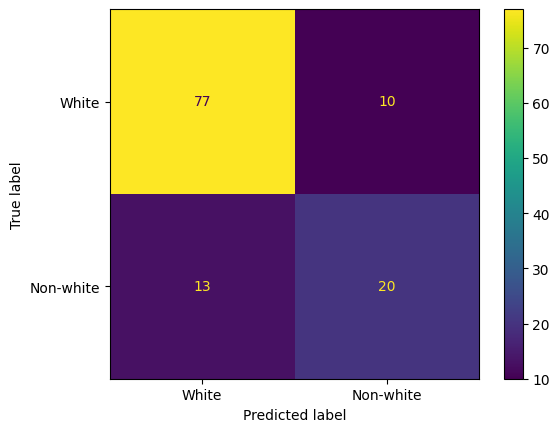

In [20]:
# Answer exercise 11

faces["White"] = np.where(faces["Race"] == "W", "White", "Non-white")

X = faces[['Luminance_median', 'Nose_Width', 'Nose_Length',
       'Lip_Thickness']] 
y = faces["White"]

print(y.value_counts())

from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42) #split data
model = KNeighborsClassifier(n_neighbors=5) 
model.fit(X_train, y_train)#fit model
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

from sklearn.metrics import ConfusionMatrixDisplay 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["White", "Non-white"]) 
disp.plot() 

print("Accuracy test: ", model.score(X_test, y_test))


## Exercise 12

Look up how to use the CNN algorithm: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

- Use the CNN algorithm from the imblearn package (from imblearn.under_sampling import CondensedNearestNeighbour)
- Apply it to X and y
- Print the value counts of the two classes
- Train the k-NN with k = 5
- Plot the confusion matrix
- Plot the accuracy on the test set
- How do you explain the lower accuracy than before?

White
White        183
Non-white    117
Name: count, dtype: int64
Accuracy test:  0.55


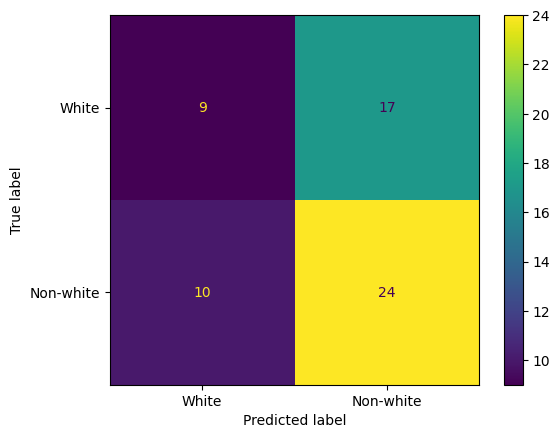

In [21]:
#Answer exercise 12
from imblearn.under_sampling import CondensedNearestNeighbour
cnn = CondensedNearestNeighbour(random_state=42)  
X_res, y_res = cnn.fit_resample(X, y)

print(y_res.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state = 42) #split data
model = KNeighborsClassifier(n_neighbors=5) 
model.fit(X_train, y_train)#fit model
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["White", "Non-white"]) 
disp.plot() 

print("Accuracy test: ", model.score(X_test, y_test))
#Lower accuracy than before, because the model can no longer rely on predicting the majority class to get a good performance.


# Decision trees

Decision trees partition the feature space into sections based on rules such as lip_thickness < 0.4. Decision tree can be used to predict a class (e.g., "Race") or a continuous variable (e.g., "Age").

## Exercise 13

Check the documentation of sklearn on decision trees and apply the decision tree to predict "Race" from 'Luminance_median', 'Nose_Width', 'Nose_Length',and 'Lip_Thickness'.

- Split the data between training (80%) and test (20%)
- Predict race with the default decision tree using 'Luminance_median', 'Nose_Width', 'Nose_Length',and 'Lip_Thickness'.
- Compute the accurace on the training and test sets.
- Is there a sign of overfitting?

The documentation page: https://scikit-learn.org/stable/modules/tree.html

In [22]:
from sklearn import tree

X = faces[['Luminance_median', 'Nose_Width', 'Nose_Length','Lip_Thickness']]
y = faces['Race']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

tree_model = tree.DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
train_acc_tree = tree_model.score(X_train, y_train)
test_acc_tree = tree_model.score(X_test, y_test)
print("Accuracy train/test LR:", train_acc_tree, test_acc_tree)
#much higher accuracy on the training than test, strongly suggestive of overfitting.

Accuracy train/test LR: 1.0 0.575


You can plot the tree with the following code. It shows that the tree is extremely large (in line with the overfitting).

[Text(0.2385177752293578, 0.96875, 'x[0] <= 135.25\ngini = 0.732\nsamples = 477\nvalue = [84, 152, 91, 150]'),
 Text(0.06422018348623854, 0.90625, 'x[0] <= 129.25\ngini = 0.146\nsamples = 156\nvalue = [5, 144, 5, 2]'),
 Text(0.03302752293577982, 0.84375, 'x[3] <= 104.0\ngini = 0.043\nsamples = 137\nvalue = [2, 134, 1, 0]'),
 Text(0.014678899082568808, 0.78125, 'x[3] <= 101.5\ngini = 0.444\nsamples = 3\nvalue = [1, 2, 0, 0]'),
 Text(0.007339449541284404, 0.71875, 'gini = 0.0\nsamples = 2\nvalue = [0, 2, 0, 0]'),
 Text(0.022018348623853212, 0.71875, 'gini = 0.0\nsamples = 1\nvalue = [1, 0, 0, 0]'),
 Text(0.05137614678899083, 0.78125, 'x[2] <= 187.75\ngini = 0.03\nsamples = 134\nvalue = [1, 132, 1, 0]'),
 Text(0.03669724770642202, 0.71875, 'x[0] <= 113.5\ngini = 0.444\nsamples = 3\nvalue = [1, 2, 0, 0]'),
 Text(0.029357798165137616, 0.65625, 'gini = 0.0\nsamples = 2\nvalue = [0, 2, 0, 0]'),
 Text(0.044036697247706424, 0.65625, 'gini = 0.0\nsamples = 1\nvalue = [1, 0, 0, 0]'),
 Text(0.0660

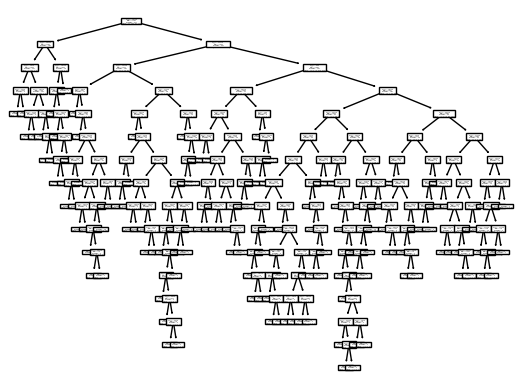

In [23]:
tree.plot_tree(tree_model)

# Decision tree pruning

When you get a large tree, and consequently overfitting, you can "prune" the three. This can be done before or after fitting the model. Before fitting the model is easiest: You indicate how large the tree can be. Below you find an example.

Accuracy train/test LR: 0.6834381551362684 0.6916666666666667


[Text(0.3333333333333333, 0.875, 'Luminance_median <= 135.25\ngini = 0.732\nsamples = 477\nvalue = [84, 152, 91, 150]'),
 Text(0.16666666666666666, 0.625, 'gini = 0.146\nsamples = 156\nvalue = [5, 144, 5, 2]'),
 Text(0.5, 0.625, 'Nose_Width <= 217.75\ngini = 0.654\nsamples = 321\nvalue = [79.0, 8.0, 86.0, 148.0]'),
 Text(0.3333333333333333, 0.375, 'gini = 0.412\nsamples = 130\nvalue = [13, 1, 19, 97]'),
 Text(0.6666666666666666, 0.375, 'Lip_Thickness <= 99.5\ngini = 0.685\nsamples = 191\nvalue = [66.0, 7.0, 67.0, 51.0]'),
 Text(0.5, 0.125, 'gini = 0.559\nsamples = 41\nvalue = [4.0, 0.0, 14.0, 23.0]'),
 Text(0.8333333333333334, 0.125, 'gini = 0.667\nsamples = 150\nvalue = [62, 7, 53, 28]')]

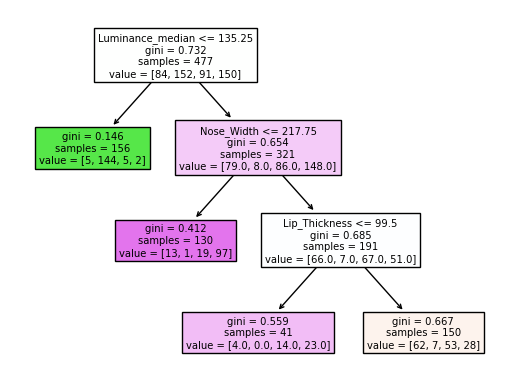

In [24]:
tree_model = tree.DecisionTreeClassifier(max_leaf_nodes= 4)
tree_model.fit(X_train, y_train)
train_acc_tree = tree_model.score(X_train, y_train)
test_acc_tree = tree_model.score(X_test, y_test)
print("Accuracy train/test LR:", train_acc_tree, test_acc_tree)
tree.plot_tree(tree_model, filled=True, feature_names = X_train.columns)


## Exercise 14

Look up the other parameters of the decision tree and examine for one of these what the effect of this parameter is on:
* The accuracy on the training and test set
* The size of the tree

Do this for 3 levels of the parameter (e.g., max leaf nodes = 4, 6, and 8).

Accuracy train/test LR: 1.0 0.6166666666666667
Accuracy train/test LR: 1.0 0.6
Accuracy train/test LR: 1.0 0.5916666666666667


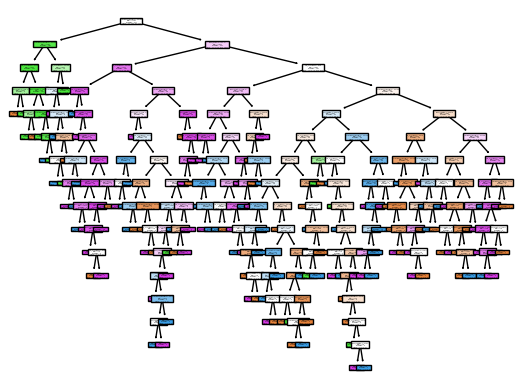

In [25]:
#Answer exercise 14
#We here examine the effect of max_features

nr_features = [3, 5, 7]

for nr_feature in nr_features:
    tree_model = tree.DecisionTreeClassifier(max_features = nr_feature)
    tree_model.fit(X_train, y_train)
    train_acc_tree = tree_model.score(X_train, y_train)
    test_acc_tree = tree_model.score(X_test, y_test)
    print("Accuracy train/test LR:", train_acc_tree, test_acc_tree)
    tree.plot_tree(tree_model, filled=True, feature_names = X_train.columns)

#Overfitting seems to increase with a higher values of max_features


It is also possible to prune the tree after fitting it. We make use of the code in: https://www.geeksforgeeks.org/pruning-decision-trees/

The first step in post-pruning is to determine the cost complexity pruning path. This determines the impurity of the leaves as a function of the effective alpha. According to the documentation of sklearn: "The weakest link is characterized by an effective alpha". So alpha provides a means to find the weakest links in a tree (which you may want to prune).

The impurity of a leaf indicates how many of the training items that end up in that leaf have the same class. For example, if you train for gender, an impure leaf has 60% females, whereas a pure leaf has 100% females. Ideally you want to have pure leaves.

We first use the code to examine the path.

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

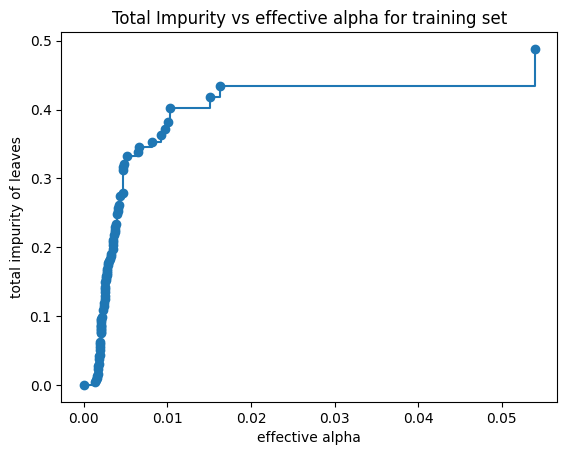

In [26]:
import matplotlib.pyplot as plt
tree_model = tree.DecisionTreeClassifier() # return to tree without restricting parameters
path = tree_model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

And follow with the remainder of the code to post-prune the tree.

In [27]:
from sklearn.tree import DecisionTreeClassifier
pruned_models = []
for ccp_alpha in ccp_alphas:
    pruned_model = DecisionTreeClassifier(criterion="gini", ccp_alpha=ccp_alpha)
pruned_model.fit(X_train, y_train)
pruned_models.append(pruned_model)

# Find the model with the best accuracy on test data
best_accuracy = 0
best_pruned_model = None
for pruned_model in pruned_models:
    accuracy = pruned_model.score(X_test, y_test)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_pruned_model = pruned_model
# Model Accuracy after pruning
train_accuracy_after_pruning = best_pruned_model.score(X_train, y_train)
test_accuracy_after_pruning = best_pruned_model.score(X_test, y_test)
print("Train/test accuracy after pruning:", train_accuracy_after_pruning, test_accuracy_after_pruning)
#The train and test accuracy are now much more similar.

Train/test accuracy after pruning: 0.31865828092243187 0.375


# Leaf impurity

We already saw the concept of impurity. Because we were predicting race (4 classes), it is a bit more difficult to imagine what impurity looks like. We therefore now focus on predicting gender from a range of facial features.


Accuracy train/test LR: 0.7148846960167715 0.6833333333333333


[Text(0.6, 0.8333333333333334, 'ChinLength <= 0.189\ngini = 0.499\nsamples = 477\nvalue = [247.0, 230.0]'),
 Text(0.4, 0.5, 'Luminance_median <= 84.5\ngini = 0.448\nsamples = 295\nvalue = [195, 100]'),
 Text(0.2, 0.16666666666666666, 'gini = 0.18\nsamples = 20\nvalue = [2, 18]'),
 Text(0.6, 0.16666666666666666, 'gini = 0.419\nsamples = 275\nvalue = [193, 82]'),
 Text(0.8, 0.5, 'gini = 0.408\nsamples = 182\nvalue = [52, 130]')]

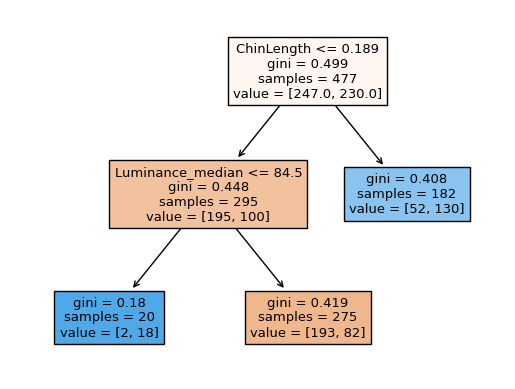

In [28]:
X = faces[['Luminance_median', 'Nose_Width', 'Nose_Length','Lip_Thickness', 'Face_Length', 'Avg_Eye_Height', 'Forehead', 'Face_Width_Mouth', 'LipFullness', 'EyeShape', 'EyeSize', 'UpperHeadLength',
       'MidfaceLength', 'ChinLength', 'ForeheadHeight', 'CheekboneHeight', 'CheekboneProminence', 'FaceRoundness']]
y = faces['Gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

tree_model = tree.DecisionTreeClassifier(max_leaf_nodes= 3)
tree_model.fit(X_train, y_train)
train_acc_tree = tree_model.score(X_train, y_train)
test_acc_tree = tree_model.score(X_test, y_test)
print("Accuracy train/test LR:", train_acc_tree, test_acc_tree)
tree.plot_tree(tree_model, filled=True, feature_names = X_train.columns)


## Exercise 15

The gini index is a measure of leaf impurity. Look up what levels of the gini index indicate a low and a high leaf impurity. Which leaves are impure in the above tree?

To examine which observation ended up in which node, we can use the decision path. For our (rather small) decision tree, the columns with the names 2, 3, and 4 are leaves. 

In [38]:
tree_path = pd.DataFrame(tree_model.decision_path(X_train).toarray())
tree_path["Gender"] = y
print(tree_path.columns)
tree_path["Leaf"] = np.where(tree_path[2] == 1, 2, 0)
tree_path["Leaf"] = np.where(tree_path[3] == 1, 3, tree_path["Leaf"])
tree_path["Leaf"] = np.where(tree_path[4] == 1, 4, tree_path["Leaf"])

print(tree_path.head())

print(tree_path["Leaf"].value_counts())


Index([0, 1, 2, 3, 4, 'Gender'], dtype='object')
   0  1  2  3  4 Gender  Leaf
0  1  1  0  0  1      F     4
1  1  1  0  0  1      F     4
2  1  1  0  0  1      F     4
3  1  1  0  0  1      F     4
4  1  1  0  0  1      F     4
Leaf
4    275
2    182
3     20
Name: count, dtype: int64


## Exercise 16

Determine how pure each leaf is by computing the percentage "F" responses per leaf (from the "Leaf" column). Which is the purest tree? Does this correspond to the Gini values that you saw earlier?

In [39]:
# Exercise 16 answer
tree_path["gender_bin"] = np.where(tree_path["Gender"] == "F", 1, 0) #create a variable that you can average to compute the percentage
perc = tree_path.groupby(["Leaf"])["gender_bin"].mean().reset_index() #compute the average per leaf
perc["gender_bin"] = perc["gender_bin"]*100 #convert to percentage
perc.head()

#The Gini index seems to be computed against the "male" class. Leaf 3 is the purest from the three, because it has the highest percentage of the same class. The Gini index does not seem to scale linearly: There is around 12% difference between leaf 3 and leaf 2 and 4, but the Gini index almost dubles. 


,Leaf,gender_bin
0,2,57.692308
1,3,70.000000
2,4,58.545455


# Regression trees

Decision trees can also be used to perform regression.

## Exercise 17

Look up the documentation of regression trees at: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

- Select the relevant columns for X and y
- Split the data into training and test
- Predict age from the ratings for BabyFace, Dominant and Attractive with a regression tree with max_leaf_nodes= 4
- Compute the mean squared error for the training and the test set
- Plot the tree

MSe train/test: 20.230523092546875 21.356818176187957


[Text(0.5, 0.8333333333333334, 'Babyface <= 1.736\nsquared_error = 40.501\nsamples = 477\nvalue = 28.868'),
 Text(0.25, 0.5, 'Babyface <= 1.232\nsquared_error = 41.48\nsamples = 62\nvalue = 38.646'),
 Text(0.125, 0.16666666666666666, 'squared_error = 8.713\nsamples = 10\nvalue = 46.262'),
 Text(0.375, 0.16666666666666666, 'squared_error = 34.482\nsamples = 52\nvalue = 37.182'),
 Text(0.75, 0.5, 'Babyface <= 2.414\nsquared_error = 23.936\nsamples = 415\nvalue = 27.407'),
 Text(0.625, 0.16666666666666666, 'squared_error = 23.568\nsamples = 211\nvalue = 29.652'),
 Text(0.875, 0.16666666666666666, 'squared_error = 13.71\nsamples = 204\nvalue = 25.085')]

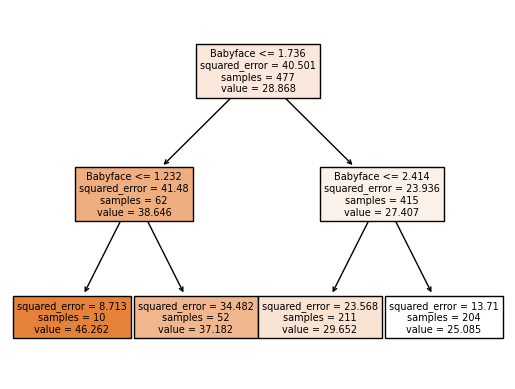

In [60]:
#Exercise 17
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
X = faces[['Babyface', 'Dominant', 'Attractive']] #select the columns
y = faces['Age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 2) #split the data

tree_model =  DecisionTreeRegressor(random_state=2, criterion = "squared_error", max_leaf_nodes= 4) #set the criterion to mse
tree_model.fit(X_train, y_train) #fit the model

train_pred = tree_model.predict(X_train) #to compute the MSE you need the predicted values
train_mse = mean_squared_error(train_pred, y_train)

test_pred = tree_model.predict(X_test)
test_mse = mean_squared_error(test_pred, y_test)

print("MSe train/test:", train_mse, test_mse)

tree.plot_tree(tree_model, filled=True, feature_names = X_train.columns)

# Rule extraction from trees

The plots of the decision tree already show what rules are used to classify elements. These can be converted to text as follows.

In [67]:
from sklearn.tree import export_text

X = faces[['Luminance_median', 'Nose_Width', 'Nose_Length','Lip_Thickness', 'Face_Length', 'Avg_Eye_Height', 'Forehead', 'Face_Width_Mouth', 'LipFullness', 'EyeShape', 'EyeSize', 'UpperHeadLength',
       'MidfaceLength', 'ChinLength', 'ForeheadHeight', 'CheekboneHeight', 'CheekboneProminence', 'FaceRoundness']]
y = faces['Gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

tree_model = tree.DecisionTreeClassifier(max_leaf_nodes= 3)
tree_model.fit(X_train, y_train)
tree_model = tree_model.fit(X_train, y_train) #fit the model

text_rep = export_text(tree_model, feature_names=X.columns)
print(text_rep)

|--- ChinLength <= 0.19
|   |--- Luminance_median <= 84.50
|   |   |--- class: M
|   |--- Luminance_median >  84.50
|   |   |--- class: F
|--- ChinLength >  0.19
|   |--- class: M



## Exercise 18

Increase the max_leaf_nodes to 10 and print the rules.

In [68]:
#Exercise 18

from sklearn.tree import export_text

X = faces[['Luminance_median', 'Nose_Width', 'Nose_Length','Lip_Thickness', 'Face_Length', 'Avg_Eye_Height', 'Forehead', 'Face_Width_Mouth', 'LipFullness', 'EyeShape', 'EyeSize', 'UpperHeadLength',
       'MidfaceLength', 'ChinLength', 'ForeheadHeight', 'CheekboneHeight', 'CheekboneProminence', 'FaceRoundness']]
y = faces['Gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

tree_model = tree.DecisionTreeClassifier(max_leaf_nodes= 10)
tree_model.fit(X_train, y_train)
tree_model = tree_model.fit(X_train, y_train) #fit the model

text_rep = export_text(tree_model, feature_names=X.columns)
print(text_rep)

|--- ChinLength <= 0.19
|   |--- Luminance_median <= 84.50
|   |   |--- class: M
|   |--- Luminance_median >  84.50
|   |   |--- ChinLength <= 0.15
|   |   |   |--- class: F
|   |   |--- ChinLength >  0.15
|   |   |   |--- EyeSize <= 0.05
|   |   |   |   |--- class: M
|   |   |   |--- EyeSize >  0.05
|   |   |   |   |--- MidfaceLength <= 0.36
|   |   |   |   |   |--- CheekboneProminence <= 0.05
|   |   |   |   |   |   |--- class: M
|   |   |   |   |   |--- CheekboneProminence >  0.05
|   |   |   |   |   |   |--- class: F
|   |   |   |   |--- MidfaceLength >  0.36
|   |   |   |   |   |--- class: M
|--- ChinLength >  0.19
|   |--- Luminance_median <= 174.25
|   |   |--- FaceRoundness <= 0.51
|   |   |   |--- class: M
|   |   |--- FaceRoundness >  0.51
|   |   |   |--- Nose_Length <= 243.50
|   |   |   |   |--- class: F
|   |   |   |--- Nose_Length >  243.50
|   |   |   |   |--- class: M
|   |--- Luminance_median >  174.25
|   |   |--- class: F



# Ripper algorithm

Ripper stands for: Repeated Incremental Pruning to Produce Error Reduction and therefore is a pruning method (see https://www.geeksforgeeks.org/ripper-algorithm/).

As one of the use cases it is listed: "It works well on datasets with imbalanced class distributions."

So let's create a class imbalance and see how to use Ripper.


## Exercise 19

- Convert the column "Race" to the value 1 for "W" and value 0 for all other races
- Create X from the columns: 'Luminance_median', 'Nose_Width', 'Nose_Length','Lip_Thickness'
- Create y from the new race-column (which indicates whether the face is white or not)                                          

In [69]:
faces["race_bin"] = np.where(faces["Race"] == "W", 1, 0)
X = faces[["Luminance_median", "Nose_Width", "Nose_Length","Lip_Thickness"]]
y = faces["race_bin"]

There does not seem to be an implementation of the ripper algorithm. 

It is contained in: https://github.com/Waikato/weka-3.8/blob/master/weka/src/main/java/weka/classifiers/rules/JRip.java

In the following exercise we use a fitted decision tree to apply the algorithm (normally you would look at the data to decide on the rules, but we now cheat by first fitting the decision tree).

According to: https://christophm.github.io/interpretable-ml-book/rules.html

The idea of ripper is as follows: 

"The idea is simple: First, find a good rule that applies to some of the data points. Remove all data points which are covered by the rule. A data point is covered when the conditions apply, regardless of whether the points are classified correctly or not. Repeat the rule-learning and removal of covered points with the remaining points until no more points are left or another stop condition is met. The result is a decision list. This approach of repeated rule-learning and removal of covered data points is called “separate-and-conquer”."

We first start with fitting a tree and plotting it.

[Text(0.4, 0.8333333333333334, 'Nose_Width <= 218.75\ngini = 0.431\nsamples = 477\nvalue = [327, 150]'),
 Text(0.2, 0.5, 'gini = 0.438\nsamples = 151\nvalue = [49, 102]'),
 Text(0.6, 0.5, 'Lip_Thickness <= 99.5\ngini = 0.251\nsamples = 326\nvalue = [278, 48]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.495\nsamples = 42\nvalue = [19.0, 23.0]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.161\nsamples = 284\nvalue = [259, 25]')]

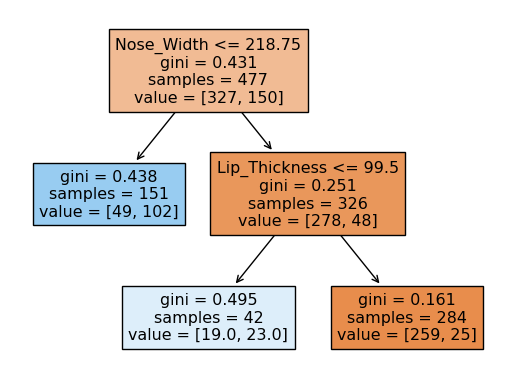

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

tree_model = tree.DecisionTreeClassifier(max_leaf_nodes= 3)
tree_model.fit(X_train, y_train)
tree_model = tree_model.fit(X_train, y_train) #fit the model
tree.plot_tree(tree_model, filled=True, feature_names = X_train.columns)

## Exercise 20

- Create a data-frame with X_train and y_train combined
- Print the number of rows in the data-frame
- The first rule is nose_width <= 218.75: Remove all instances from the data-frame where the nose width is smaller than 218.75
- Print the number of remaining rows

In [78]:
#Exercise 20

df = pd.concat([X.reset_index(drop=True), y], axis=1)
print(len(df))
df = df[df["Nose_Width"] > 218.75]
print(len(df))


597
409


## Exercise 21

- Now remove all elements with a lip thickness of less than 99.5
- Make a scatterplot of Lip thickness against nose width for the remaining points

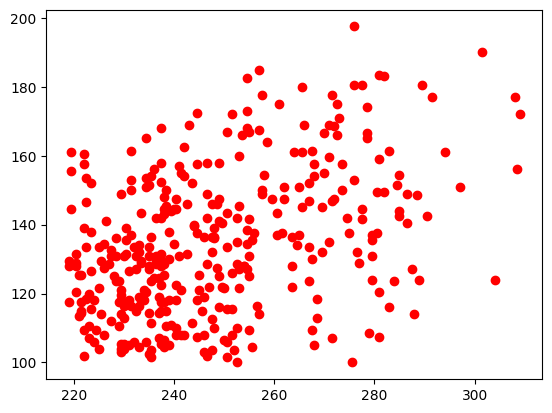

In [80]:
# Exercise 21

df = df[df["Lip_Thickness"] > 99.5]

plt.plot(df["Nose_Width"].values, df["Lip_Thickness"].values, "ro")

This is not the full algorithm (for more details, see https://christophm.github.io/interpretable-ml-book/rules.html) and we would normally look at the data to define a rule (or use a theory). The above two exercises therefore only serve to get a sense of how the algorithm works.